In [ ]:
import torch
import torchvision.models
import numpy as np
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim #for gradient descent
import matplotlib.pyplot as plt

In [ ]:
import random
import math
import os
import requests

In [ ]:
from torchvision import datasets
import torchvision.transforms.v2
from torch.utils.data import DataLoader, Subset
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
class RGBToBGR(nn.Module):
    """Converts Tensors or PIL images from RGB to BGR (or vice versa)."""

    def forward(self, x):
        if isinstance(x, torch.Tensor):
            if x.ndim not in (3, 4):
                raise ValueError('Tensor must have 3 or 4 dimensions.')
            if x.shape[-3] != 3:
                raise ValueError('Tensor must have three channels.')
            return x.flip(dims=[-3])
        elif isinstance(x, Image.Image):
            x = x.convert('RGB')
            return Image.merge('RGB', x.split()[::-1])
        raise TypeError('Argument must be either Tensor or PIL image.')

In [ ]:
# Load your dataset and preprocess it
transform_normal = torchvision.transforms.v2.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[116.047 / 255, 113.753 / 255, 105.417 / 255], std=[1 / 255]),
    RGBToBGR()
])

transform_color = torchvision.transforms.v2.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ColorJitter(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[116.047 / 255, 113.753 / 255, 105.417 / 255], std=[1 / 255])
])

transform_rotate = torchvision.transforms.v2.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.v2.RandomApply(transforms=[
        torchvision.transforms.RandomRotation(degrees=(90,90)),
        torchvision.transforms.RandomRotation(degrees=(180,180)),
        torchvision.transforms.RandomRotation(degrees=(270,270))], p=0.5),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[116.047 / 255, 113.753 / 255, 105.417 / 255], std=[1 / 255])
])

transform_rotate1 = torchvision.transforms.v2.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.RandomRotation(degrees=(90,90)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[116.047 / 255, 113.753 / 255, 105.417 / 255], std=[1 / 255])
])

transform_rotate2 = torchvision.transforms.v2.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.RandomRotation(degrees=(180,180)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[116.047 / 255, 113.753 / 255, 105.417 / 255], std=[1 / 255])
])

transform_rotate3 = torchvision.transforms.v2.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.RandomRotation(degrees=(270,270)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[116.047 / 255, 113.753 / 255, 105.417 / 255], std=[1 / 255])
])

transform_fliph = torchvision.transforms.v2.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[116.047 / 255, 113.753 / 255, 105.417 / 255], std=[1 / 255])
])

transform_flipv = torchvision.transforms.v2.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[116.047 / 255, 113.753 / 255, 105.417 / 255], std=[1 / 255])
])

#transform_rotate = torchvision.transforms.v2.RandomApply(transforms=[transform_rotate1, transform_rotate2,transform_rotate3], p=1)

transform_list = [transform_normal, transform_color, transform_rotate1, transform_rotate2,transform_rotate3, transform_fliph, transform_flipv]

In [ ]:
data_dir = '/content/gdrive/My Drive/APS360 Group Project/datax256_n_500/datax256_n_500'

train_dir = os.path.join(data_dir, 'train/')
val_dir = os.path.join(data_dir, 'val/')
test_dir = os.path.join(data_dir, 'test/')
#splitfolders.ratio(data_dir, output=data_dir, seed=1337, ratio=(.8, 0.1,0.1))

train_datasets = []

#for trans in transform_list:
    # Create datasets and dataloaders for training, validation, and test sets
    #train_datasets.append(datasets.ImageFolder(train_dir, transform=trans))

from torch.utils.data import ConcatDataset
#train_dataset = ConcatDataset(train_datasets)
train_dataset = datasets.ImageFolder(train_dir, transform=transform_normal)
val_dataset = datasets.ImageFolder(val_dir, transform=transform_normal)
test_dataset = datasets.ImageFolder(test_dir, transform=transform_normal)

In [ ]:
class placesClassifier(nn.Module):
    def __init__(self):
        super(placesClassifier, self).__init__()
        self.fc1 = nn.Linear(205, 50)
        self.fc2 = nn.Linear(50, 4)

    def forward(self, x):
        x1 = F.relu(self.fc1(x))
        x2 = self.fc2(x1)
        return x2

class placesMerged(nn.Module):

    def __init__(self, model1, model2):
        super().__init__()

        self.model1 = model1
        self.model2 = model2


    def forward(self, x):
        x1 = self.model1(x)
        x2 = self.model2(x1)

        return x2

In [ ]:
import numpy as np
from sklearn import svm
import torch

use_cuda = True

# Extract features using GoogLeNet
def extract_features2(model, bs, dataset):
    dataloader = DataLoader(dataset, batch_size=bs, shuffle=True, pin_memory=True)
    features = []
    labels = []
    for data, label in dataloader:
        data = data.cuda()  # Move data to the same device as the model
        with torch.no_grad():  # Ensure that no gradients are calculated
            output = model(data)  # Assuming GoogLeNet returns both output and auxillary output
            if isinstance(output, torch.Tensor):  # Check if the output is a tensor
                output = output.cpu().detach().numpy()  # Convert tensor to numpy array
            features.append(output)
            labels.append(label.numpy())
    features = np.concatenate(features)
    labels = np.concatenate(labels)
    return features, labels

def extract_features2_2(model, bs, dataloader, labels):
    features = []
    dataloader = dataloader.cuda()  # Move data to the same device as the model
    with torch.no_grad():  # Ensure that no gradients are calculated
        output = model(dataloader)  # Assuming GoogLeNet returns both output and auxillary output
        if isinstance(output, torch.Tensor):  # Check if the output is a tensor
            output = output.cpu().detach().numpy()  # Convert tensor to numpy array
        features.append(output)
        labels = labels.numpy()
    features = np.concatenate(features)
    return features, labels

# Flatten the extracted features
def flatten_features(features):
    return features.reshape(features.shape[0], -1)

# Train SVM classifier
def train_svm(features, labels):
    clf = svm.SVC(kernel='linear')
    clf.fit(features, labels)
    return clf

# Evaluate SVM classifier
def evaluate_svm(clf, features, labels):
    accuracy = clf.score(features, labels)
    return accuracy

In [ ]:
#link for caffe to pytorch code below: https://github.com/crowsonkb/pytorch-caffe-models/tree/master

from PIL import Image
import torch
from torch import nn
from torchvision import transforms as T

import torch
from torch import nn


class Inception(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super().__init__()
        self.conv_1x1 = nn.Conv2d(in_channels, ch1x1, 1)
        self.relu_1x1 = nn.ReLU(inplace=True)
        self.conv_3x3_reduce = nn.Conv2d(in_channels, ch3x3red, 1)
        self.relu_3x3_reduce = nn.ReLU(inplace=True)
        self.conv_3x3 = nn.Conv2d(ch3x3red, ch3x3, 3, padding=1)
        self.relu_3x3 = nn.ReLU(inplace=True)
        self.conv_5x5_reduce = nn.Conv2d(in_channels, ch5x5red, 1)
        self.relu_5x5_reduce = nn.ReLU(inplace=True)
        self.conv_5x5 = nn.Conv2d(ch5x5red, ch5x5, 5, padding=2)
        self.relu_5x5 = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(3, stride=1, padding=1)
        self.pool_proj = nn.Conv2d(in_channels, pool_proj, 1)
        self.relu_pool_proj = nn.ReLU(inplace=True)

    def forward(self, x):
        branch_1 = self.relu_1x1(self.conv_1x1(x))
        branch_2 = self.relu_3x3_reduce(self.conv_3x3_reduce(x))
        branch_2 = self.relu_3x3(self.conv_3x3(branch_2))
        branch_3 = self.relu_5x5_reduce(self.conv_5x5_reduce(x))
        branch_3 = self.relu_5x5(self.conv_5x5(branch_3))
        branch_4 = self.pool(x)
        branch_4 = self.relu_pool_proj(self.pool_proj(branch_4))
        return torch.cat([branch_1, branch_2, branch_3, branch_4], dim=1)

class GoogLeNet2(nn.Sequential):
    def __init__(self, num_classes=1000):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        self.norm1 = nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75)
        self.conv2_reduce = nn.Conv2d(64, 64, kernel_size=1)
        self.relu2_reduce = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.norm2 = nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75)
        self.pool2 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        self.inception_3a = Inception(192, 64, 96, 128, 16, 32, 32)
        self.inception_3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.pool3 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        self.inception_4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception_4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception_4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception_4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception_4e = Inception(528, 256, 160, 320, 32, 128, 128)
        self.pool4 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        self.inception_5a = Inception(832, 256, 160, 320, 32, 128, 128)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.pool1(x)
        x = self.norm1(x)
        x = self.relu2_reduce(self.conv2_reduce(x))
        x = self.relu2(self.conv2(x))
        x = self.norm2(x)
        x = self.pool2(x)
        x = self.inception_3a(x)
        x = self.inception_3b(x)
        x = self.pool3(x)
        x = self.inception_4a(x)
        x = self.inception_4b(x)
        x = self.inception_4c(x)
        x = self.inception_4d(x)
        x = self.inception_4e(x)
        x = self.pool4(x)
        x = self.inception_5a(x)
        return x

class GoogLeNet(nn.Sequential):
    def __init__(self, num_classes=1000):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        self.norm1 = nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75)
        self.conv2_reduce = nn.Conv2d(64, 64, kernel_size=1)
        self.relu2_reduce = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.norm2 = nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75)
        self.pool2 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        self.inception_3a = Inception(192, 64, 96, 128, 16, 32, 32)
        self.inception_3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.pool3 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        self.inception_4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception_4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception_4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception_4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception_4e = Inception(528, 256, 160, 320, 32, 128, 128)
        self.pool4 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        self.inception_5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception_5b = Inception(832, 384, 192, 384, 48, 128, 128)
        self.pool5 = nn.AdaptiveAvgPool2d((1, 1))
        self.loss3_classifier = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.pool1(x)
        x = self.norm1(x)
        x = self.relu2_reduce(self.conv2_reduce(x))
        x = self.relu2(self.conv2(x))
        x = self.norm2(x)
        x = self.pool2(x)
        x = self.inception_3a(x)
        x = self.inception_3b(x)
        x = self.pool3(x)
        x = self.inception_4a(x)
        x = self.inception_4b(x)
        x = self.inception_4c(x)
        x = self.inception_4d(x)
        x = self.inception_4e(x)
        x = self.pool4(x)
        x = self.inception_5a(x)
        x = self.inception_5b(x)
        x = self.pool5(x).flatten(1)
        return self.loss3_classifier(x)

class Just_5b(nn.Module):
    def __init__(self):
        super(Just_5b, self).__init__()
        self.inception_5b = Inception(832, 384, 192, 384, 48, 128, 128)
        self.pool5 = nn.AdaptiveAvgPool2d((1, 1))
        self.loss3_classifier = nn.Linear(1024, 205)

    def forward(self, x):
        x = self.inception_5b(x)
        x = self.pool5(x).flatten(1)
        x = self.loss3_classifier(x)
        return x


class RGBToBGR(nn.Module):
    """Converts Tensors or PIL images from RGB to BGR (or vice versa)."""

    def forward(self, x):
        if isinstance(x, torch.Tensor):
            if x.ndim not in (3, 4):
                raise ValueError('Tensor must have 3 or 4 dimensions.')
            if x.shape[-3] != 3:
                raise ValueError('Tensor must have three channels.')
            return x.flip(dims=[-3])
        elif isinstance(x, Image.Image):
            x = x.convert('RGB')
            return Image.merge('RGB', x.split()[::-1])
        raise TypeError('Argument must be either Tensor or PIL image.')


def googlenet_places205():
    """Returns the model and preprocessing transform for the GoogLeNet
    trained on Places205.

    URL: http://places.csail.mit.edu/downloadCNN.html"""

    transform = T.Compose([
        T.Normalize(mean=[116.047 / 255, 113.753 / 255, 105.417 / 255], std=[1 / 255]),
        RGBToBGR(),
    ])
    model = GoogLeNet(num_classes=205)
    url = 'https://github.com/crowsonkb/pytorch-caffe-models/releases/download/models-2/googlenet_places205-b57a3fc7a34557585.pth'
    model.load_state_dict(torch.hub.load_state_dict_from_url(url, check_hash=True))
    return model, transform

def load_my_state_dict(self, state_dict):

        own_state = self.state_dict()
        for name, param in state_dict.items():
            if name not in own_state:
                 continue
            own_state[name].copy_(param)
        return own_state

In [ ]:
# Load pre-trained GoogLeNet pretrained on Places205
googlenet_places, transform = googlenet_places205()
classifier = placesClassifier()
not_5b = GoogLeNet2()
not_5b.load_state_dict(load_my_state_dict(not_5b, googlenet_places.state_dict()))
just_5b = Just_5b()

merged_net = placesMerged(just_5b, classifier)

model = merged_net

Downloading: "https://github.com/crowsonkb/pytorch-caffe-models/releases/download/models-2/googlenet_places205-b57a3fc7a34557585.pth" to /root/.cache/torch/hub/checkpoints/googlenet_places205-b57a3fc7a34557585.pth
100%|██████████| 23.6M/23.6M [00:00<00:00, 124MB/s] 


In [ ]:
use_cuda = True

if use_cuda and torch.cuda.is_available():
  model = model.cuda()
  not_5b = not_5b.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

# Freeze initial layers
for name, param in not_5b.named_parameters():
    param.requires_grad = False

# Don't freeze final layers
for name, param in model.named_parameters():
    param.requires_grad = True

saved_state_path = '/content/gdrive/My Drive/APS360 Group Project/model_state_32_10_0_01.pth'
saved_state_dict = torch.load(saved_state_path)

# Load the state dictionary into your model
model.load_state_dict(saved_state_dict)

# Ensure model is in evaluation mode
model.eval()

CUDA is available!  Training on GPU ...


placesMerged(
  (model1): Just_5b(
    (inception_5b): Inception(
      (conv_1x1): Conv2d(832, 384, kernel_size=(1, 1), stride=(1, 1))
      (relu_1x1): ReLU(inplace=True)
      (conv_3x3_reduce): Conv2d(832, 192, kernel_size=(1, 1), stride=(1, 1))
      (relu_3x3_reduce): ReLU(inplace=True)
      (conv_3x3): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu_3x3): ReLU(inplace=True)
      (conv_5x5_reduce): Conv2d(832, 48, kernel_size=(1, 1), stride=(1, 1))
      (relu_5x5_reduce): ReLU(inplace=True)
      (conv_5x5): Conv2d(48, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (relu_5x5): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
      (pool_proj): Conv2d(832, 128, kernel_size=(1, 1), stride=(1, 1))
      (relu_pool_proj): ReLU(inplace=True)
    )
    (pool5): AdaptiveAvgPool2d(output_size=(1, 1))
    (loss3_classifier): Linear(in_features=1024, out_features=205, bias=True)
  )

In [ ]:
for name, param in model.named_parameters():
    param.requires_grad = False

just_5b = model.model1
both = placesMerged(not_5b, just_5b)

train_features, train_labels = extract_features2(both, 32, train_dataset)
val_features, val_labels = extract_features2(both, 32, val_dataset)
test_features, test_labels = extract_features2(both, 32, test_dataset)

# Convert features to PyTorch tensors
train_features_tensor = torch.FloatTensor(train_features)
train_labels_tensor = torch.LongTensor(train_labels)
val_features_tensor = torch.FloatTensor(val_features)
val_labels_tensor = torch.LongTensor(val_labels)
test_features_tensor = torch.FloatTensor(test_features)
test_labels_tensor = torch.LongTensor(test_labels)

In [ ]:
from sklearn.model_selection import GridSearchCV

#classifier = model.model2

train_features_tensor = train_features_tensor.cuda().detach().cpu().numpy()
test_features_tensor = test_features_tensor.cuda().detach().cpu().numpy()
val_features_tensor = val_features_tensor.cuda().detach().cpu().numpy()

# Extract features using the trained classifier
'''
Should this be classifier(train_features_tensor) or just train_features_tensor?
'''
#train_features_classifier = classifier(train_features_tensor).detach().cpu().numpy()
#test_features_classifier = classifier(test_features_tensor).detach().cpu().numpy()
#val_features_classifier = classifier(val_features_tensor).detach().cpu().numpy()


# Define hyperparameters
svm_params = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'kernel': ['linear', 'poly', 'rbf'],  # Kernel type
    'degree': [2, 3, 4],  # Degree of the polynomial kernel
    'gamma': ['scale', 'auto']  # Gamma parameter for RBF kernel
}

# Train SVM classifier on extracted features with grid search
svm_classifier = svm.SVC()
grid_search_svm = GridSearchCV(svm_classifier, svm_params, cv=5, n_jobs=-1)
grid_search_svm.fit(train_features_tensor, train_labels)

# Get best parameters
best_params_svm = grid_search_svm.best_params_
print("Best Parameters (SVM):", best_params_svm)

# Evaluate SVM classifier with best parameters on test set
best_svm_classifier = grid_search_svm.best_estimator_

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best Parameters (SVM): {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}


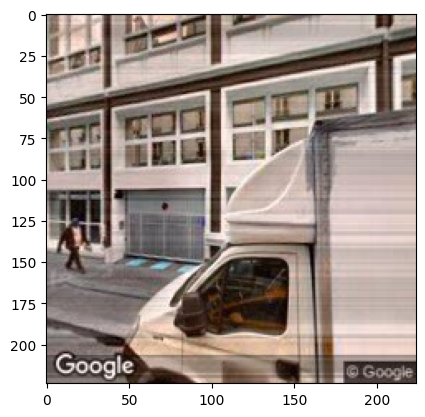

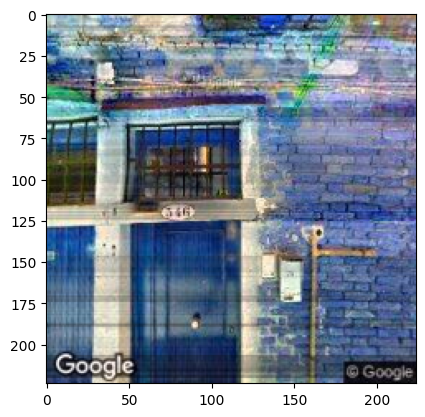

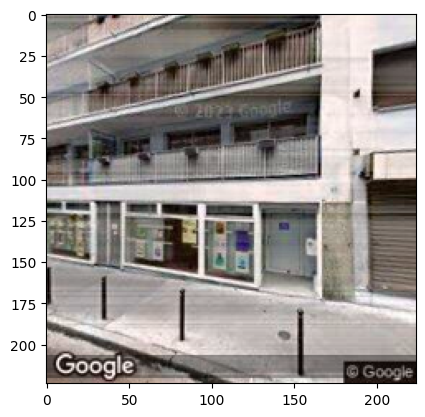

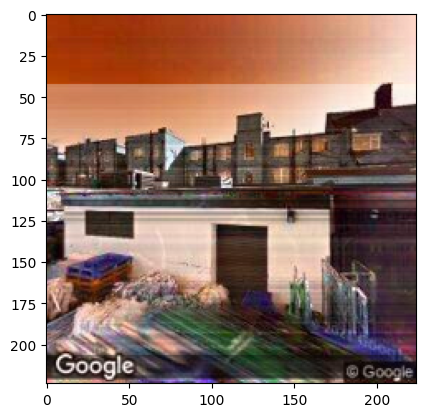

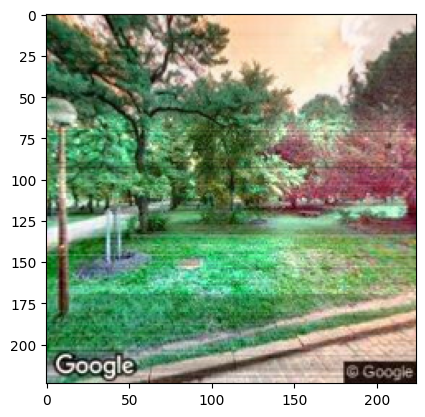

In [ ]:
# sample 5 random test images

test_loader = DataLoader(test_dataset, batch_size=5, shuffle=True)

for inputs, label in test_loader:
    imgs = inputs
    labels = label
    for img in inputs:
        image  = img.cpu().permute(1,2,0).numpy()
        # transpose image to fit plt input
        # normalise image
        data_min = np.min(image, axis=(1,2), keepdims=True)
        data_max = np.max(image, axis=(1,2), keepdims=True)
        scaled_data = (image - data_min) / (data_max - data_min)
        # show image
        plt.imshow(scaled_data)
        plt.show()

    break

In [ ]:
test_features, test_labels = extract_features2_2(both, 5, imgs, labels)

# Convert features to PyTorch tensors
test_features_tensor = torch.FloatTensor(test_features)
test_labels_tensor = torch.LongTensor(test_labels)

test_features_tensor = test_features_tensor.cuda().detach().cpu().numpy()

In [ ]:
class_names = ['barcelona', 'london', 'paris', 'venice']

test_predictions = best_svm_classifier.predict(test_features_tensor)
class_predictions = []
class_labels = []

im = 1
for pred,label in zip(test_predictions,labels):
    print(f"======= Image {im} =======")
    print(f"Predicted city: {class_names[pred]}")
    print(f"Actual city: {class_names[label]}")
    print("\n")
    im += 1

======= Image 1 =======
Predicted city: paris
Actual city: paris


======= Image 2 =======
Predicted city: venice
Actual city: venice


======= Image 3 =======
Predicted city: paris
Actual city: paris


======= Image 4 =======
Predicted city: paris
Actual city: london


======= Image 5 =======
Predicted city: london
Actual city: paris


